In [953]:
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

x_dim = 4096
y_dim = 4096
x_bits = 7000
y_bits = 7000
N = 20
X = np.random.randn(x_dim, N)
A= np.random.randn(y_dim,x_dim)
Y= A@X

X.shape, Y.shape

((4096, 20), (4096, 20))

In [954]:
Phi_X = np.random.uniform(0, 1, (x_bits,x_dim))-0.5
Phi_Y = np.random.uniform(0, 1, (y_bits,y_dim))-0.5
print(Phi_X.shape)
print(Phi_Y.shape)

(7000, 4096)
(7000, 4096)


In [955]:
x_binary = np.heaviside(Phi_X@X,0)# Equals 'q' 
y_binary = np.heaviside( Phi_Y@Y,0)# Equals 'q' 
print(x_binary.shape)
print(y_binary.shape)


(7000, 20)
(7000, 20)


In [956]:
U, S, Vt = np.linalg.svd(A, full_matrices=False)
sqrt_S = np.sqrt(S)# Compute sqrt of sigma to adjust in U and Vt

# Form the Values before projection
U_s = U @ np.diag(sqrt_S)# Adjust sigma in U and Vt
#U_s =  U

# Form the Keys before projection
V_s = Vt.T @ np.diag(sqrt_S)# Adjust sigma in Vt
#V_s = Vt.T


In [957]:
def elu(x, alpha=1.0):
    """
    Computes the Exponential Linear Unit (ELU) activation function.

    Parameters:
        x (array-like): Input data (scalar, vector, or matrix).
        alpha (float): The alpha parameter controlling the saturation for x <= 0. Default is 1.0.

    Returns:
        np.ndarray: Transformed data after applying the ELU activation.
    """
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def softmax(x):
    """
    Compute the softmax of vector x.
    
    Parameters:
    x (numpy.ndarray): Input array.
    
    Returns:
    numpy.ndarray: Output array after applying softmax.
    """
    # Subtract the max value from x for numerical stability
    #x_max = np.max(x, axis=-1, keepdims=True)
    #e_x = np.exp(x - x_max)
    eps = 0.001
    e_x = np.exp(x)+eps
    z = np.sum(e_x)
    return e_x / z

In [958]:
Values = np.heaviside(Phi_Y@ U_s,0)
Keys = np.heaviside(Phi_X@ V_s,0)

c = [0,0,1]
x_query = c[0]*V_s[:,0].reshape(-1,1) + c[1]*V_s[:,1].reshape(-1,1) + c[2]*V_s[:,1024].reshape(-1,1)
x_query = x_query/np.linalg.norm(x_query)

x_query_bits = np.heaviside( Phi_X@x_query,0) 



y_true = A@x_query
y_true_bits = np.heaviside( Phi_Y@y_true,0)

attn = Keys.T@x_query_bits.reshape(-1,1)
elu_attn = softmax(attn/np.sqrt(512))
#elu_attn = attn

y_true_bits_hat =  np.heaviside(Values@elu_attn,0)
print('bitwise accuracy',100*np.sum(y_true_bits_hat==y_true_bits)/len(y_true_bits_hat))

y_true_hat =  U@elu_attn
y_true_hat = y_true_hat/np.linalg.norm(y_true_hat)
y_true = y_true/np.linalg.norm(y_true)

print('recon. R2: ',1-(np.linalg.norm(y_true_hat-y_true)/np.linalg.norm(y_true)))
print('y_true norm', np.linalg.norm(y_true))

bitwise accuracy 49.32857142857143
recon. R2:  0.9999999999999957
y_true norm 1.0000000000000002


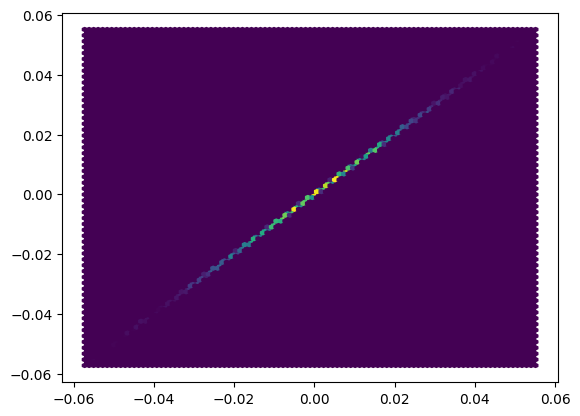

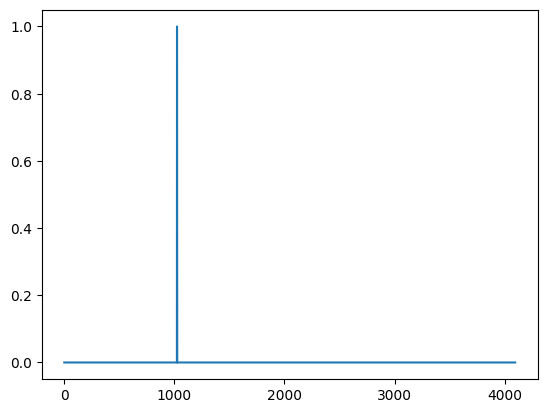

In [959]:
import matplotlib.pyplot as plt
plt.hexbin(y_true, y_true_hat)
plt.show()
plt.plot(elu_attn)

In [961]:
attn

array([[1762.],
       [1749.],
       [1652.],
       ...,
       [1758.],
       [1721.],
       [1713.]])